###  importing relevant libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:

from tabulate import tabulate
from numpy import array
from random import random
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB#57
from sklearn.naive_bayes import GaussianNB#52
from sklearn.naive_bayes import MultinomialNB#56
from sklearn.naive_bayes import CategoricalNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import csv
import math
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import time
%matplotlib inline
import xgboost

### Discovering Labels

In [3]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    df["Label"]=df["Label"].replace(renamer)
    df=df.dropna()
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [4]:
def folder(f_name): #this function creates a folder.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("Tthe folder could not be created!")

In [5]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

In [6]:
renamer={'Amazon Alexa Echo Dot 1': "Amazon Alexa Echo Dot",
 'Amazon Alexa Echo Dot 2': "Amazon Alexa Echo Dot",
 'D-Link DCHS-161 Water Sensor': 'D-Link Water Sensor',
 'DCS8000LHA1 D-Link Mini Camera': 'D-Link Mini Camera',
 'Gosund ESP_032979 Plug':'Gosund Plug',
 'Gosund ESP_039AAF Socket':'Gosund Socket',
 'Gosund ESP_0C3994 Plug': 'Gosund Plug',
 'Gosund ESP_10098F Socket':'Gosund Socket',
 'Gosund ESP_10ACD8 Plug':'Gosund Plug',
 'Gosund ESP_147FF9 Plug': 'Gosund Plug',
 'Gosund ESP_1ACEE1  Socket':'Gosund Socket',
 'Philips Hue Bridge 1': "Philips Hue Bridge",
 'Philips Hue Bridge 2': "Philips Hue Bridge",
 'Philips Hue White 1': "Philips Hue White",
 'Philips Hue White 2':"Philips Hue White",
 'Ring Base Station AC:1236': 'Ring Base Station',
 'Sengled Smart Plug 1': 'Sengled Smart Plug',
 'Sengled Smart Plug 2': 'Sengled Smart Plug',
 'SmartThings Smart Bulb 1': 'SmartThings Smart Bulb',
 'SmartThings Smart Bulb 2': 'SmartThings Smart Bulb',
 'SmartThings Smart Bulb 3': 'SmartThings Smart Bulb',
 'SmartThings Smart Bulb 4': 'SmartThings Smart Bulb',
 'SmartThings Smart Bulb 5': 'SmartThings Smart Bulb',
 'Sonoff Smart Plug 1': 'Sonoff Smart Plug',
 'Sonoff Smart Plug 2': 'Sonoff Smart Plug',
 'Teckin Plug 1':'Teckin Plug',
 'Teckin Plug 2':'Teckin Plug',
 'Yutron Plug 1': 'Yutron Plug',
 'Yutron Plug 2':  'Yutron Plug'}

In [7]:
altime=0
#def most_frequent(List): 
#    return max(set(List), key = List.count) 


 
def most_frequent(List):
    occurence_count = Counter(List)
    occurence_count={k: v for k, v in sorted(occurence_count.items(), key=lambda item: item[1],reverse=True)}
    big=list(occurence_count.values())
    big=big.count(big[0])
    return list(occurence_count.keys())[np.random.randint(big)]


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second

## Calculation of evaluations

In [8]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ml):
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,i,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time,altime]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return line,class_based_results

In [9]:


def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif
 
# Driver Code
#li1 = [10, 15, 20, 25, 30, 35, 40]
#li2 = [25, 40, 35]


In [10]:
def ML(loop1,loop2,output_csv1,cols,step,mixed,dname):

    #ths = open(output_csv, "w")
    #ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,Al-Time\n")
    

    from sklearn.metrics import balanced_accuracy_score
    from sklearn.preprocessing import Normalizer
    
    for ii in ml_list:
        #print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s'%
               #("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        output_csv=output_csv1.replace("ML",ii)
        repetition=10
        lines=[["Dataset","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T","Al-Time"]]
        for i in range(repetition):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            df=df.dropna()
            df["Label"]=df["Label"].replace(renamer)
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  
            
            

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            df=df.dropna()
            df["Label"]=df["Label"].replace(renamer)
            df = shuffle(df, random_state=42)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes


            results_y=[]
            cv+=1
            results_y.append(y_test)


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                line,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
                
                
            lines.append(line)
            df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/(repetition)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
  
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","CB.csv"))
        if True:
            cm=cm//repetition
            graph_name=output_csv+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            #print("\n\n\n")             


            #plt.clf()

            
            
            
            
            



# Machine learning applications 

# Aalto Dataset

In [11]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
'Label']


In [12]:
ml_list={"DT" :DecisionTreeClassifier()}


In [13]:
find_the_way("./","clean")

['./01.1 - Unknown-MAC-cleaning.ipynb',
 './csvs\\ACTIVE_Interactions_Test_clean.csv',
 './csvs\\ACTIVE_Interactions_Train_clean.csv',
 './csvs\\ACTIVE_Power_Test_clean.csv',
 './csvs\\ACTIVE_Power_Train_clean.csv',
 './csvs\\ACTIVE_TestInteractions_ALL_clean.csv',
 './csvs\\ACTIVE_TestPower_ALL_clean.csv',
 './csvs\\ACTIVE_TrainInteractions_ALL_clean.csv',
 './csvs\\ACTIVE_TrainPower_ALL_clean.csv',
 './csvs\\IDLE_Interactions_Test_clean.csv',
 './csvs\\IDLE_Interactions_Train_clean.csv',
 './csvs\\IDLE_Power_Test_clean.csv',
 './csvs\\IDLE_Power_Train_clean.csv',
 './csvs\\IDLE_TestInteractions_ALL_clean.csv',
 './csvs\\IDLE_TestPower_ALL_clean.csv',
 './csvs\\IDLE_TrainInteractions_ALL_clean.csv',
 './csvs\\IDLE_TrainPower_ALL_clean.csv',
 './csvs\\Interactions_ALL_clean.csv',
 './csvs\\Interactions_Test_clean.csv',
 './csvs\\Interactions_Train_clean.csv',
 './csvs\\Power_ALL_clean.csv',
 './csvs\\Power_Test_clean.csv',
 './csvs\\Power_Train_clean.csv',
 './results\\other\\@ACTIVE_I

In [14]:
./csvs/ACTIVE_TrainInteractions_ALL_clean.csv
./csvs/ACTIVE_TrainPower_ALL_clean.csv
./csvs/IDLE_TrainInteractions_ALL_clean.csv
./csvs/IDLE_TrainPower_ALL_clean.csv
./csvs/ACTIVE_TestInteractions_ALL_clean.csv
./csvs/ACTIVE_TestPower_ALL_clean.csv
./csvs/IDLE_TestInteractions_ALL_clean.csv
./csvs/IDLE_TestPower_ALL_clean.csv

SyntaxError: invalid syntax (3629588086.py, line 1)

In [18]:
TT=["./csvs/ACTIVE_TrainInteractions_ALL_clean.csv",
"./csvs/ACTIVE_TrainPower_ALL_clean.csv"]

T=["./csvs/ACTIVE_TestInteractions_ALL_clean.csv",
"./csvs/ACTIVE_TestPower_ALL_clean.csv"]


ACTIVE_TrainInteractions_ALL_clean-ACTIVE_TestInteractions_ALL_clean
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.891    0.782   0.835  0.782  0.784  0.883      0    2.831     0.299          0
 1  results/other/1_1    1     2  DT    0.891    0.782   0.835  0.782  0.783  0.883      0    2.961     0.285          0
 2  results/other/1_1    2     3  DT    0.891    0.782   0.837  0.782  0.783  0.883      0    2.96      0.237          0
 3  results/other/1_1    3     4  DT    0.891    0.782   0.835  0.782  0.783  0.883      0    3.075     0.254          0
 4  results/other/1_1    4     5  DT    0.891    0.782   0.837  0.782  0.784  0.883      0    2.956     0.27           0
 5  results/other/1_1    5     6  DT    0.891    0.782   0.835  0.782  0.783  0.883 

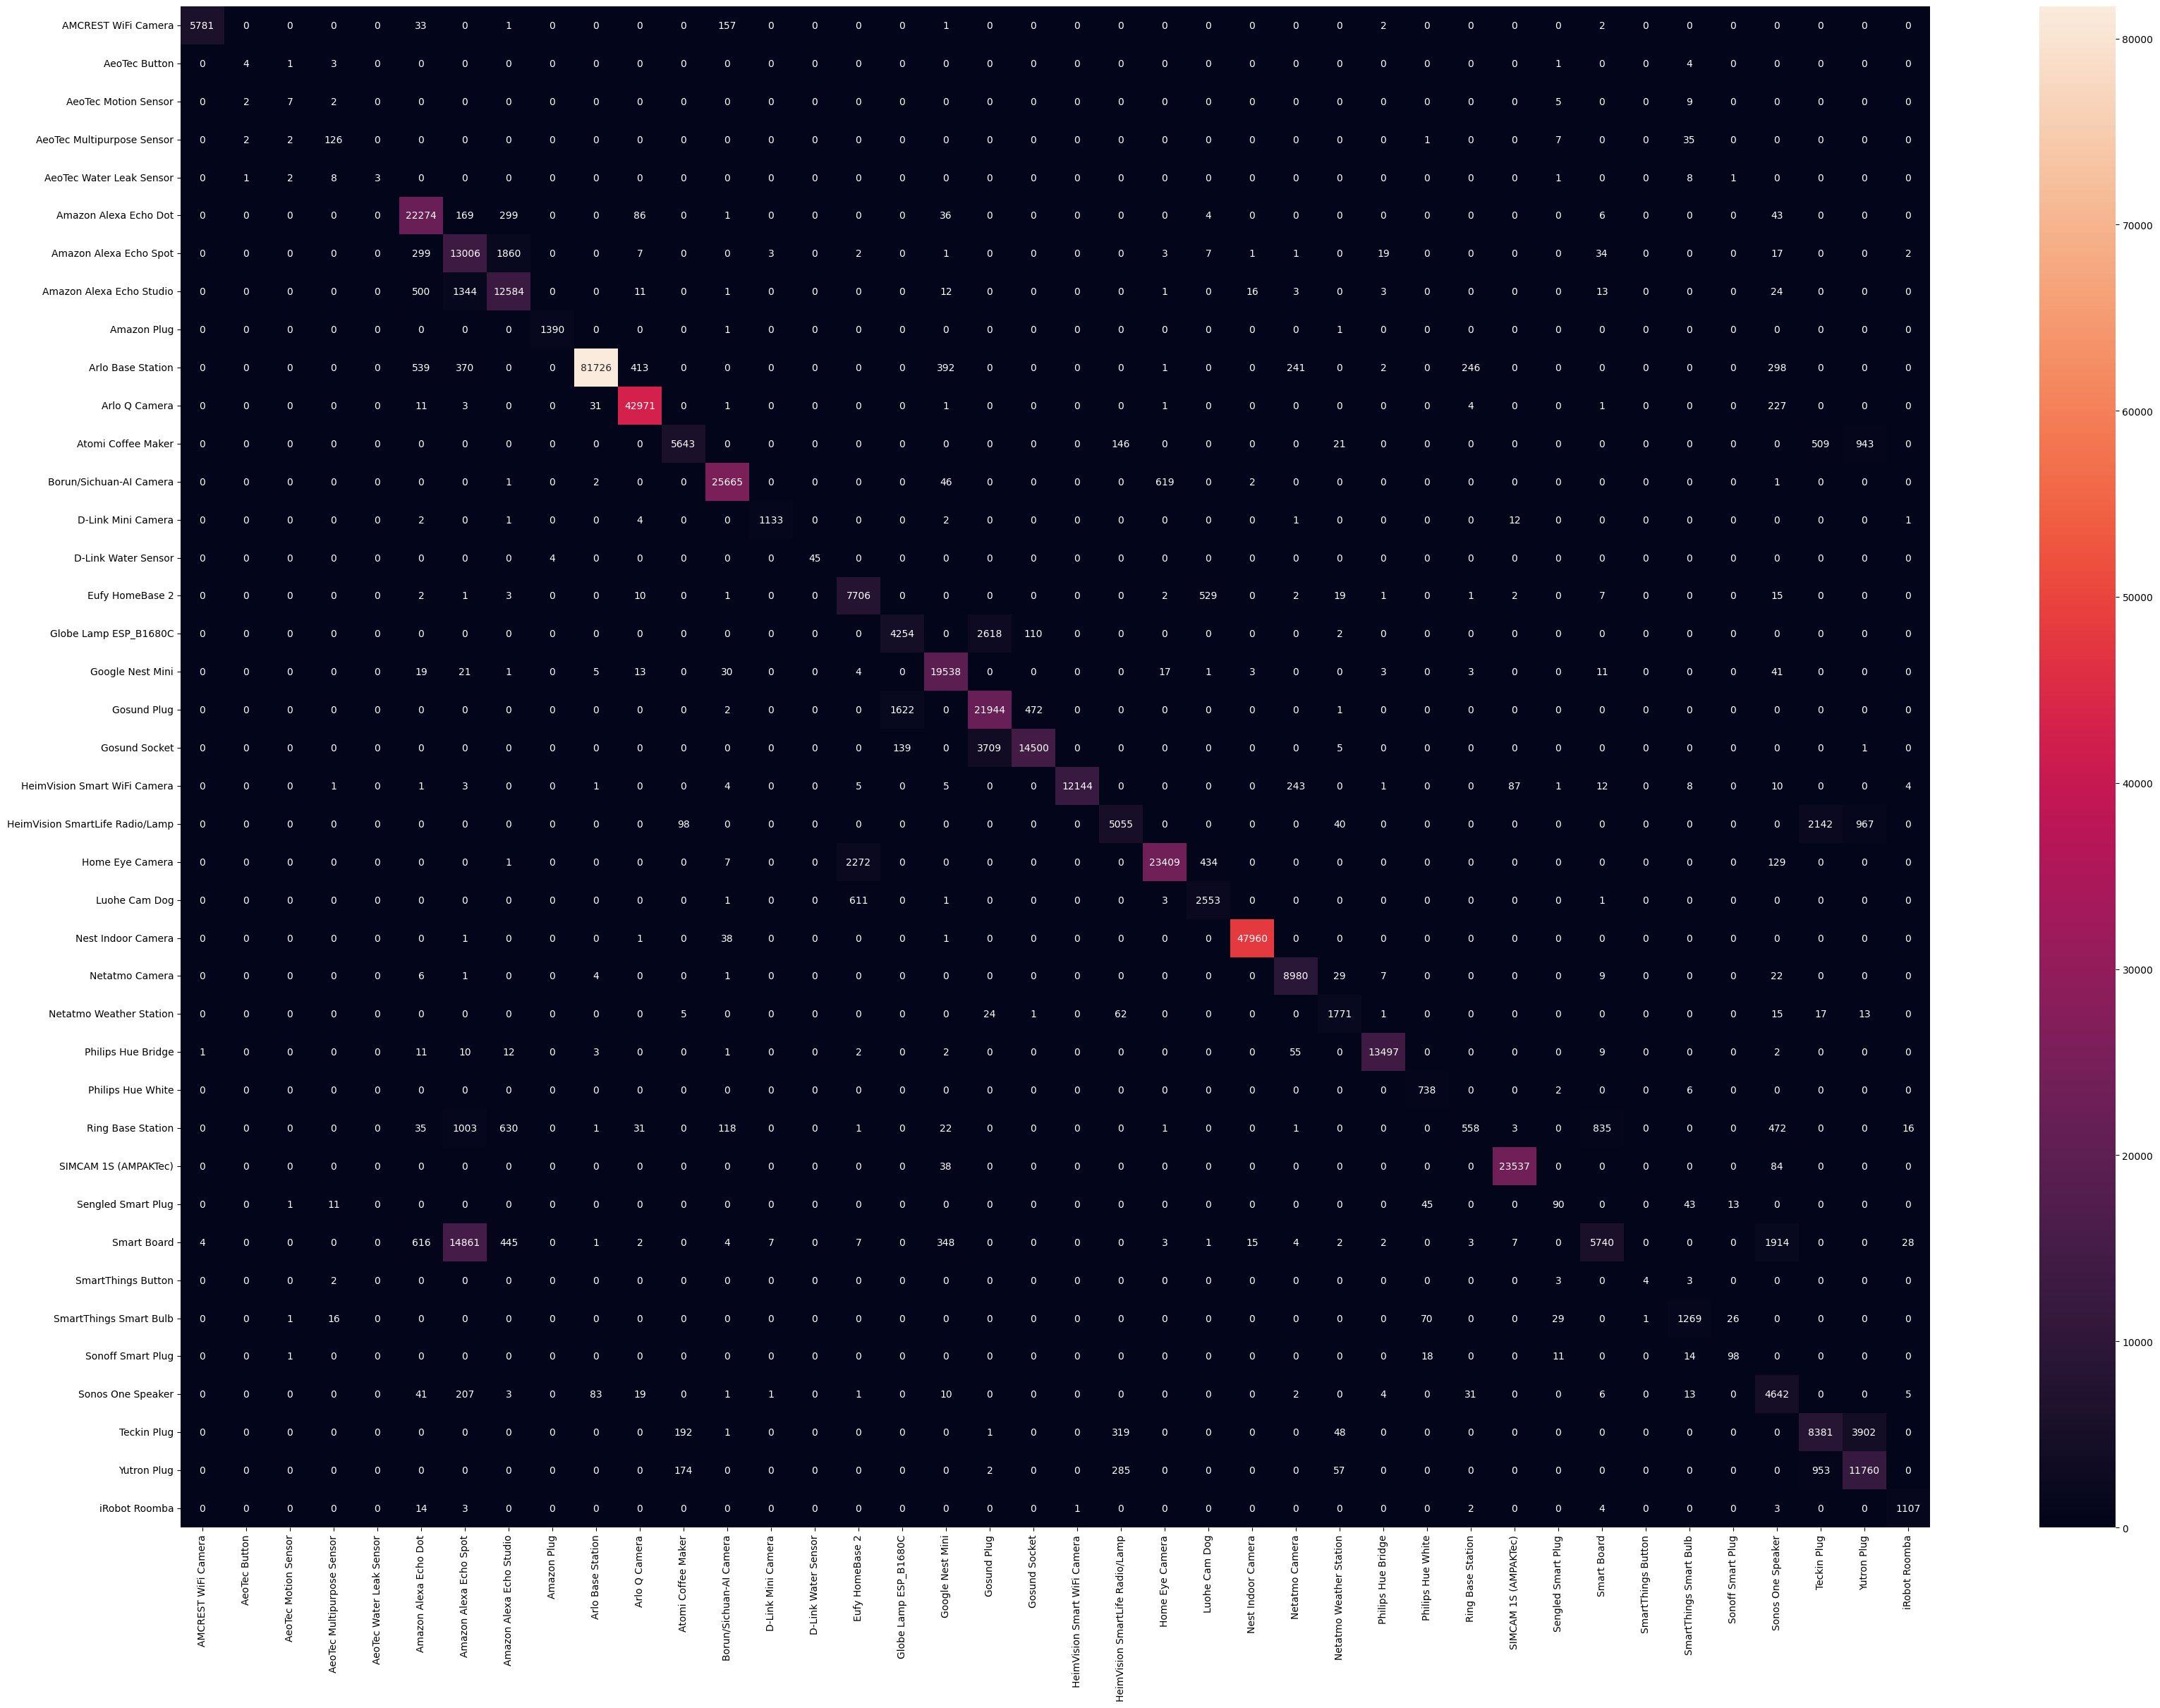

ACTIVE_TrainInteractions_ALL_clean-ACTIVE_TestPower_ALL_clean
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.886    0.735   0.757  0.735  0.715  0.878      0    2.96      0.252          0
 1  results/other/1_1    1     2  DT    0.886    0.735   0.757  0.735  0.715  0.878      0    2.885     0.265          0
 2  results/other/1_1    2     3  DT    0.886    0.735   0.757  0.735  0.715  0.878      0    2.964     0.254          0
 3  results/other/1_1    3     4  DT    0.886    0.734   0.758  0.734  0.714  0.878      0    2.914     0.254          0
 4  results/other/1_1    4     5  DT    0.886    0.735   0.757  0.735  0.715  0.878      0    3.043     0.269          0
 5  results/other/1_1    5     6  DT    0.886    0.734   0.758  0.734  0.716  0.878      0 

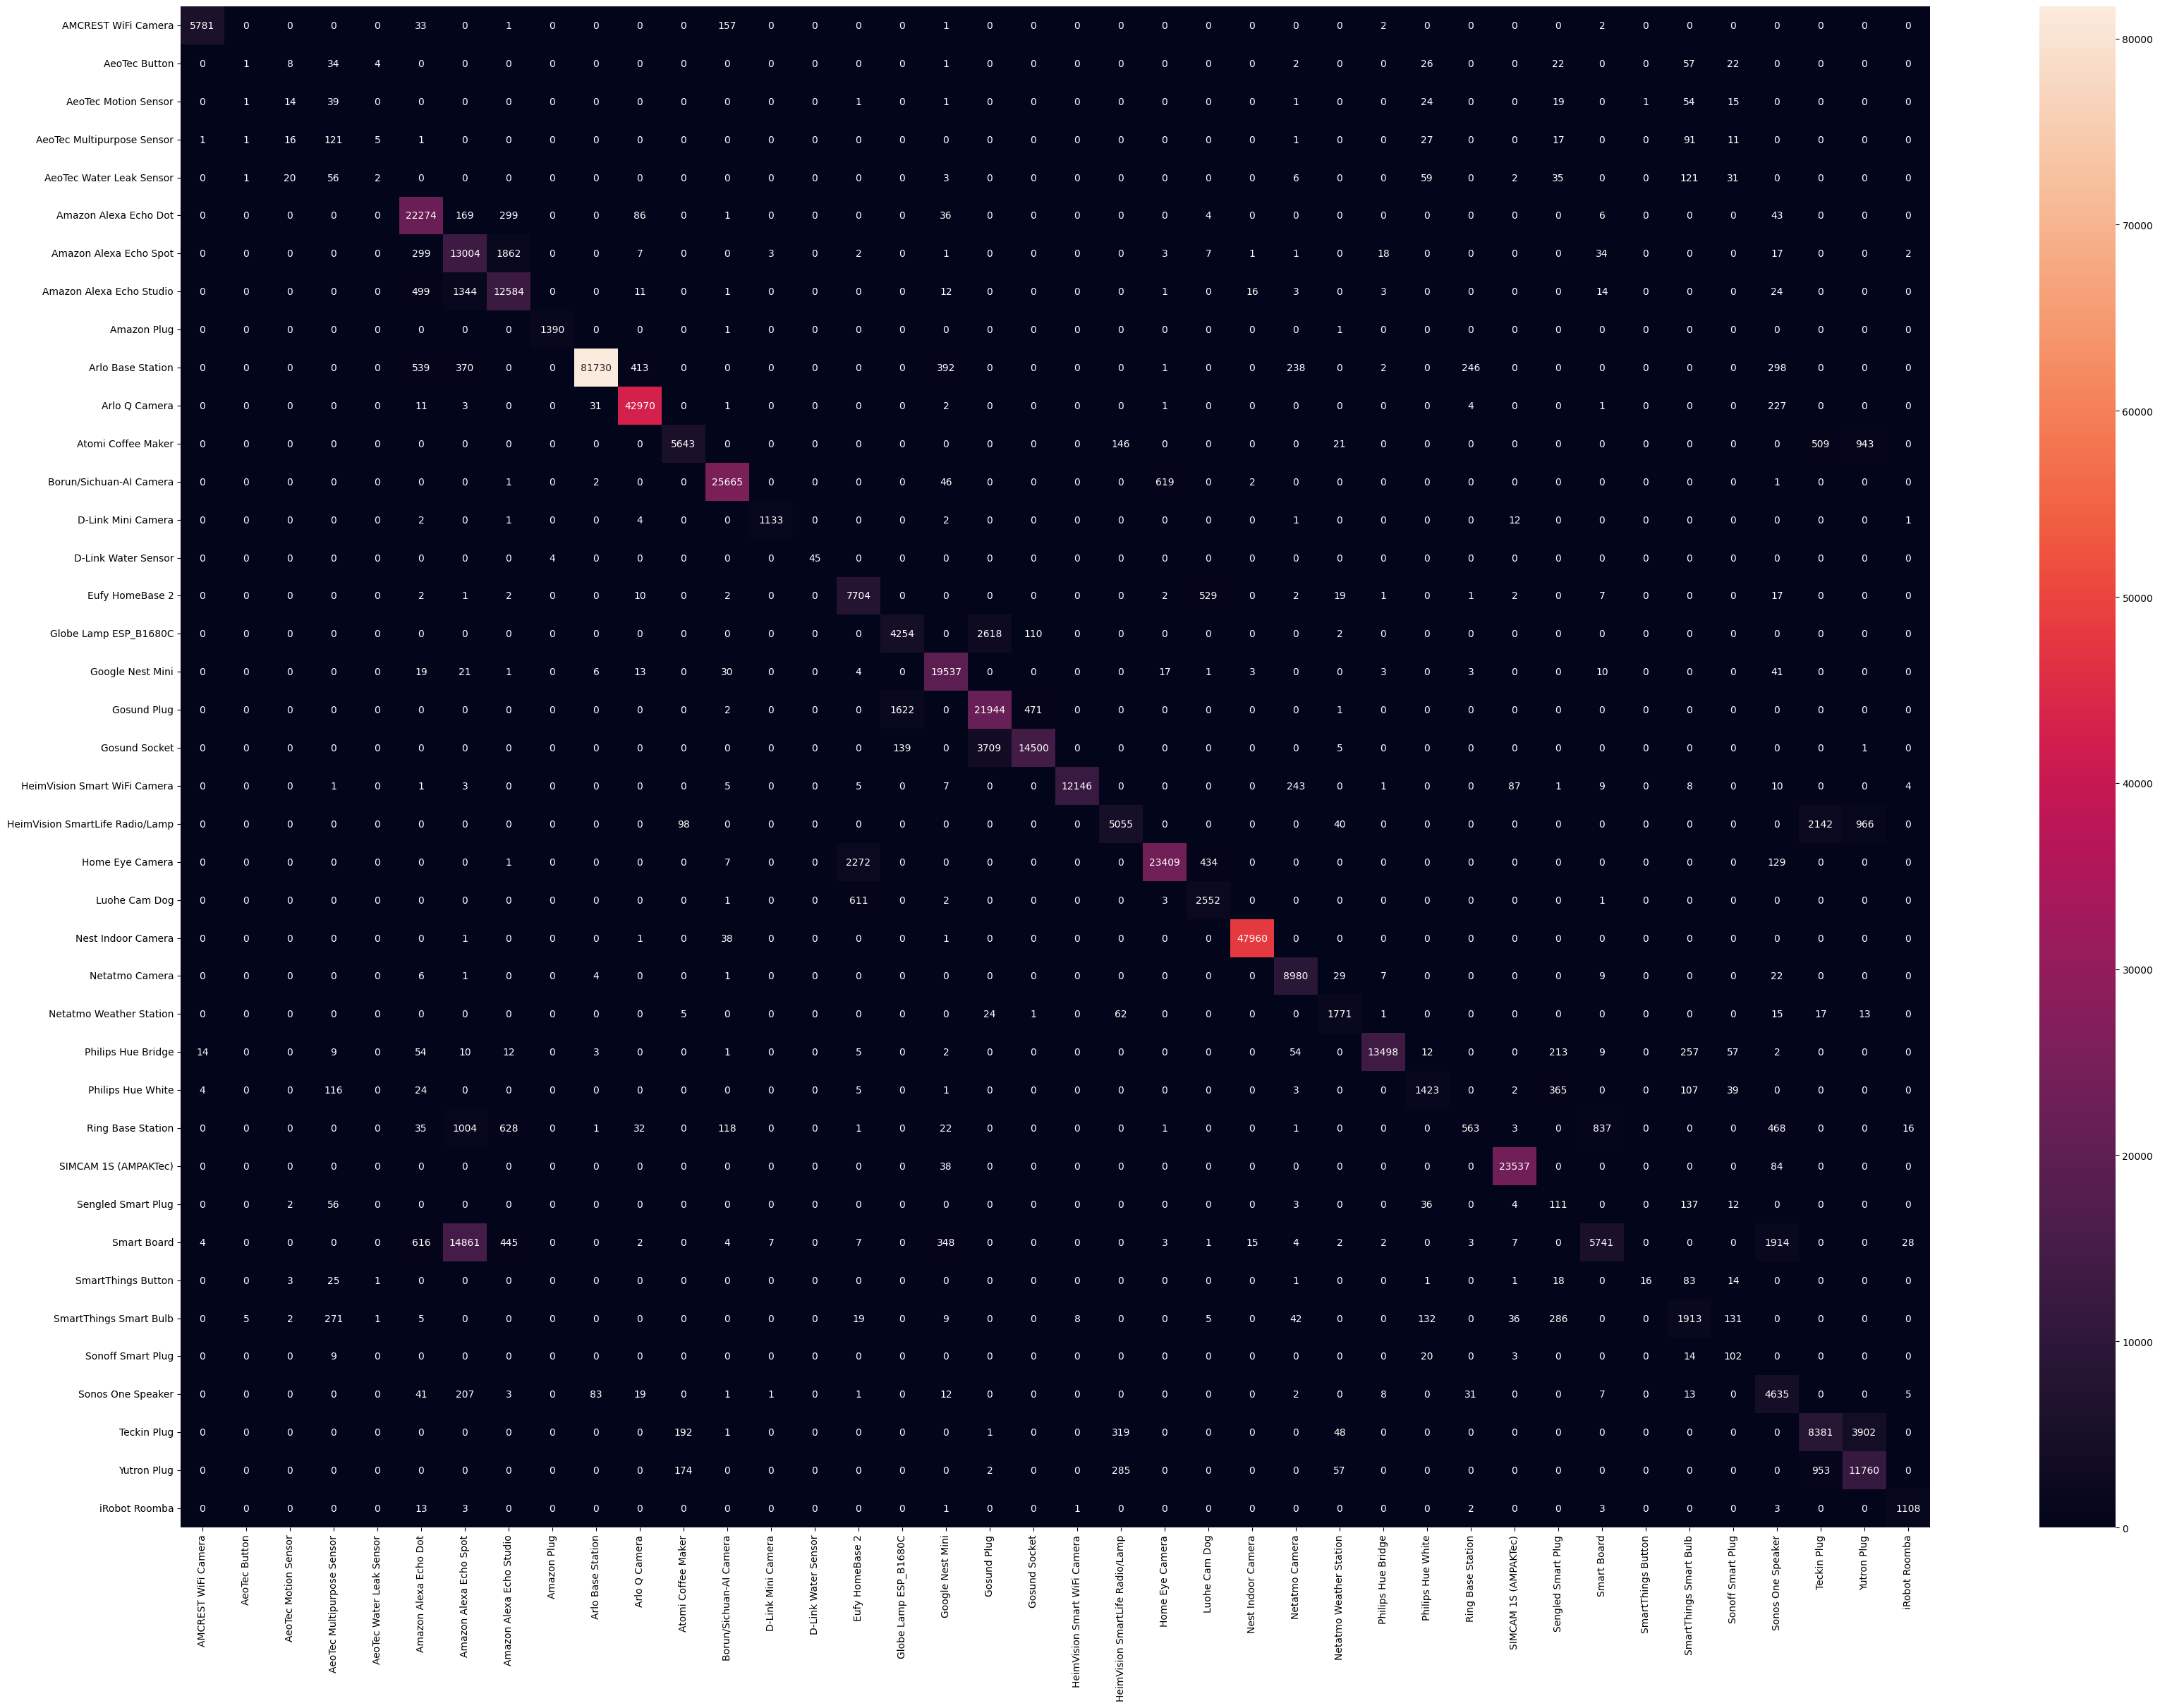

ACTIVE_TrainPower_ALL_clean-ACTIVE_TestInteractions_ALL_clean
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT     0.89     0.74   0.761   0.74  0.726  0.882      0    2.741     0.239          0
 1  results/other/1_1    1     2  DT     0.89     0.74   0.762   0.74  0.726  0.883      0    2.942     0.237          0
 2  results/other/1_1    2     3  DT     0.89     0.74   0.76    0.74  0.726  0.882      0    2.983     0.245          0
 3  results/other/1_1    3     4  DT     0.89     0.74   0.76    0.74  0.726  0.882      0    2.801     0.274          0
 4  results/other/1_1    4     5  DT     0.89     0.74   0.76    0.74  0.726  0.883      0    2.728     0.231          0
 5  results/other/1_1    5     6  DT     0.89     0.74   0.76    0.74  0.726  0.883      0 

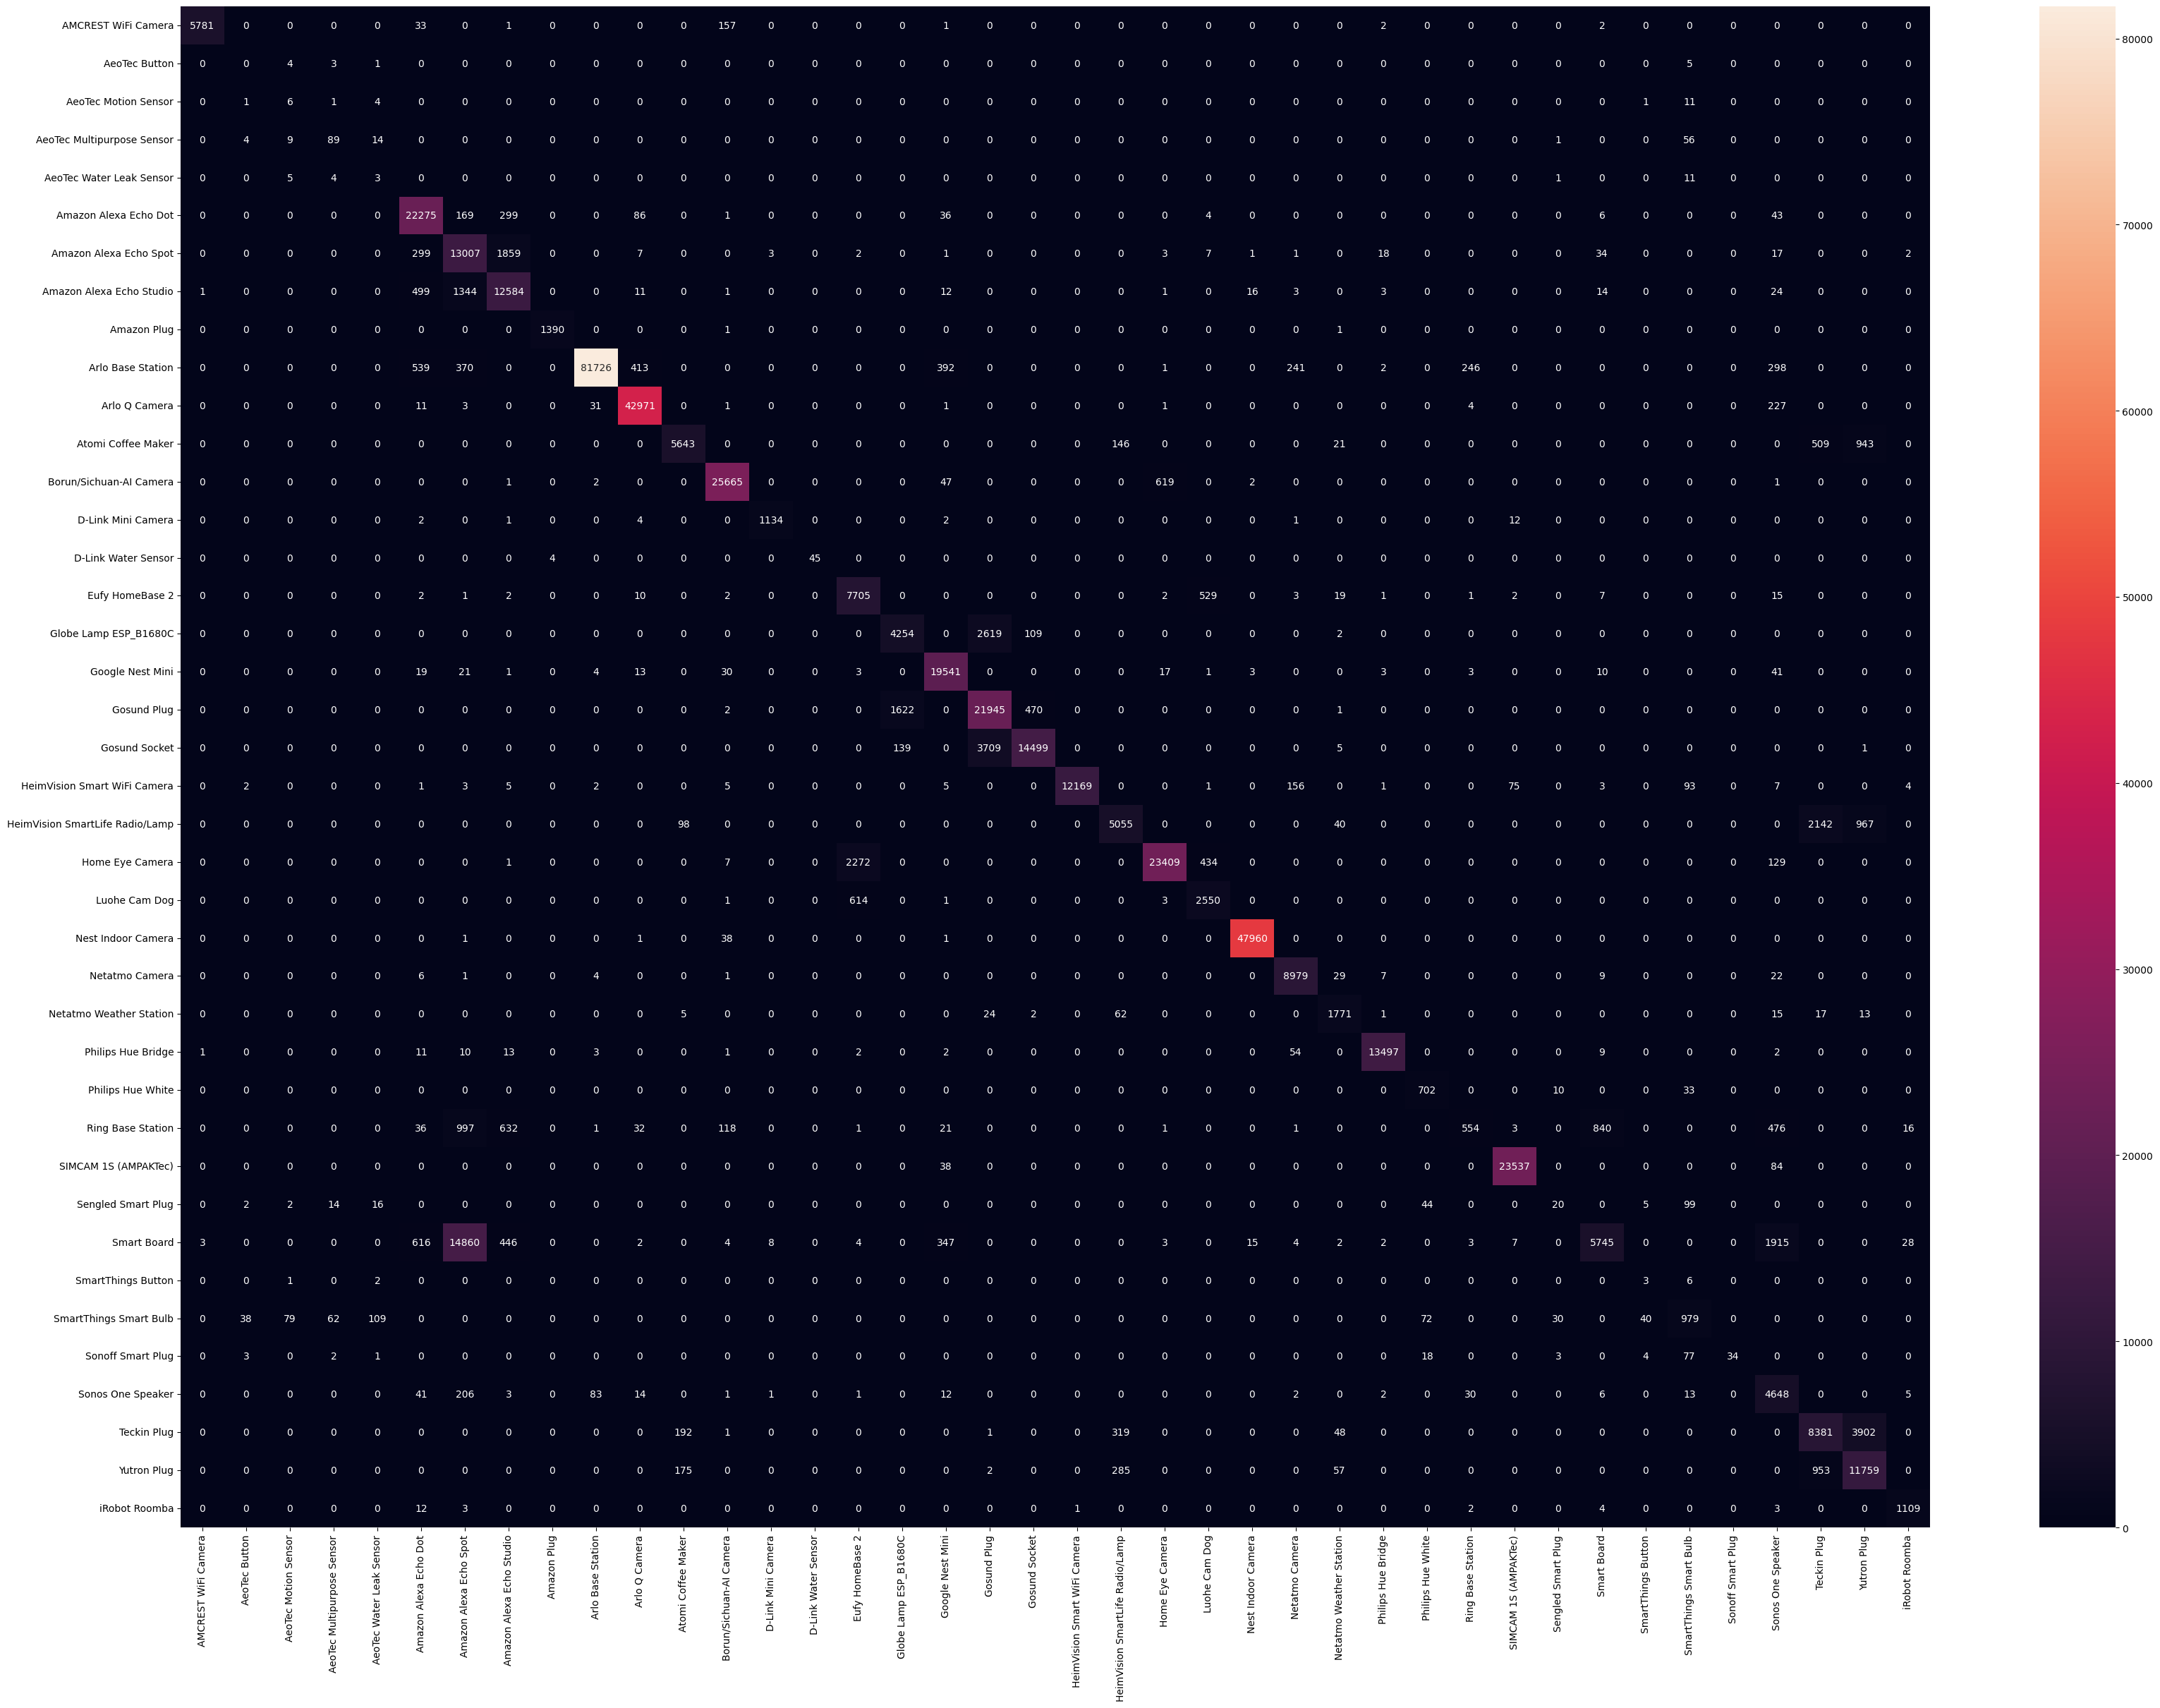

ACTIVE_TrainPower_ALL_clean-ACTIVE_TestPower_ALL_clean
    Dataset              T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -----------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/1_1    0     1  DT    0.891    0.805   0.837  0.805  0.806  0.883      0    3.332     0.314          0
 1  results/other/1_1    1     2  DT    0.891    0.805   0.838  0.805  0.806  0.883      0    3.362     0.298          0
 2  results/other/1_1    2     3  DT    0.891    0.805   0.837  0.805  0.806  0.883      0    2.853     0.266          0
 3  results/other/1_1    3     4  DT    0.891    0.805   0.836  0.805  0.805  0.883      0    2.875     0.26           0
 4  results/other/1_1    4     5  DT    0.891    0.805   0.838  0.805  0.805  0.883      0    3.035     0.255          0
 5  results/other/1_1    5     6  DT    0.891    0.805   0.837  0.805  0.806  0.883      0    2.85

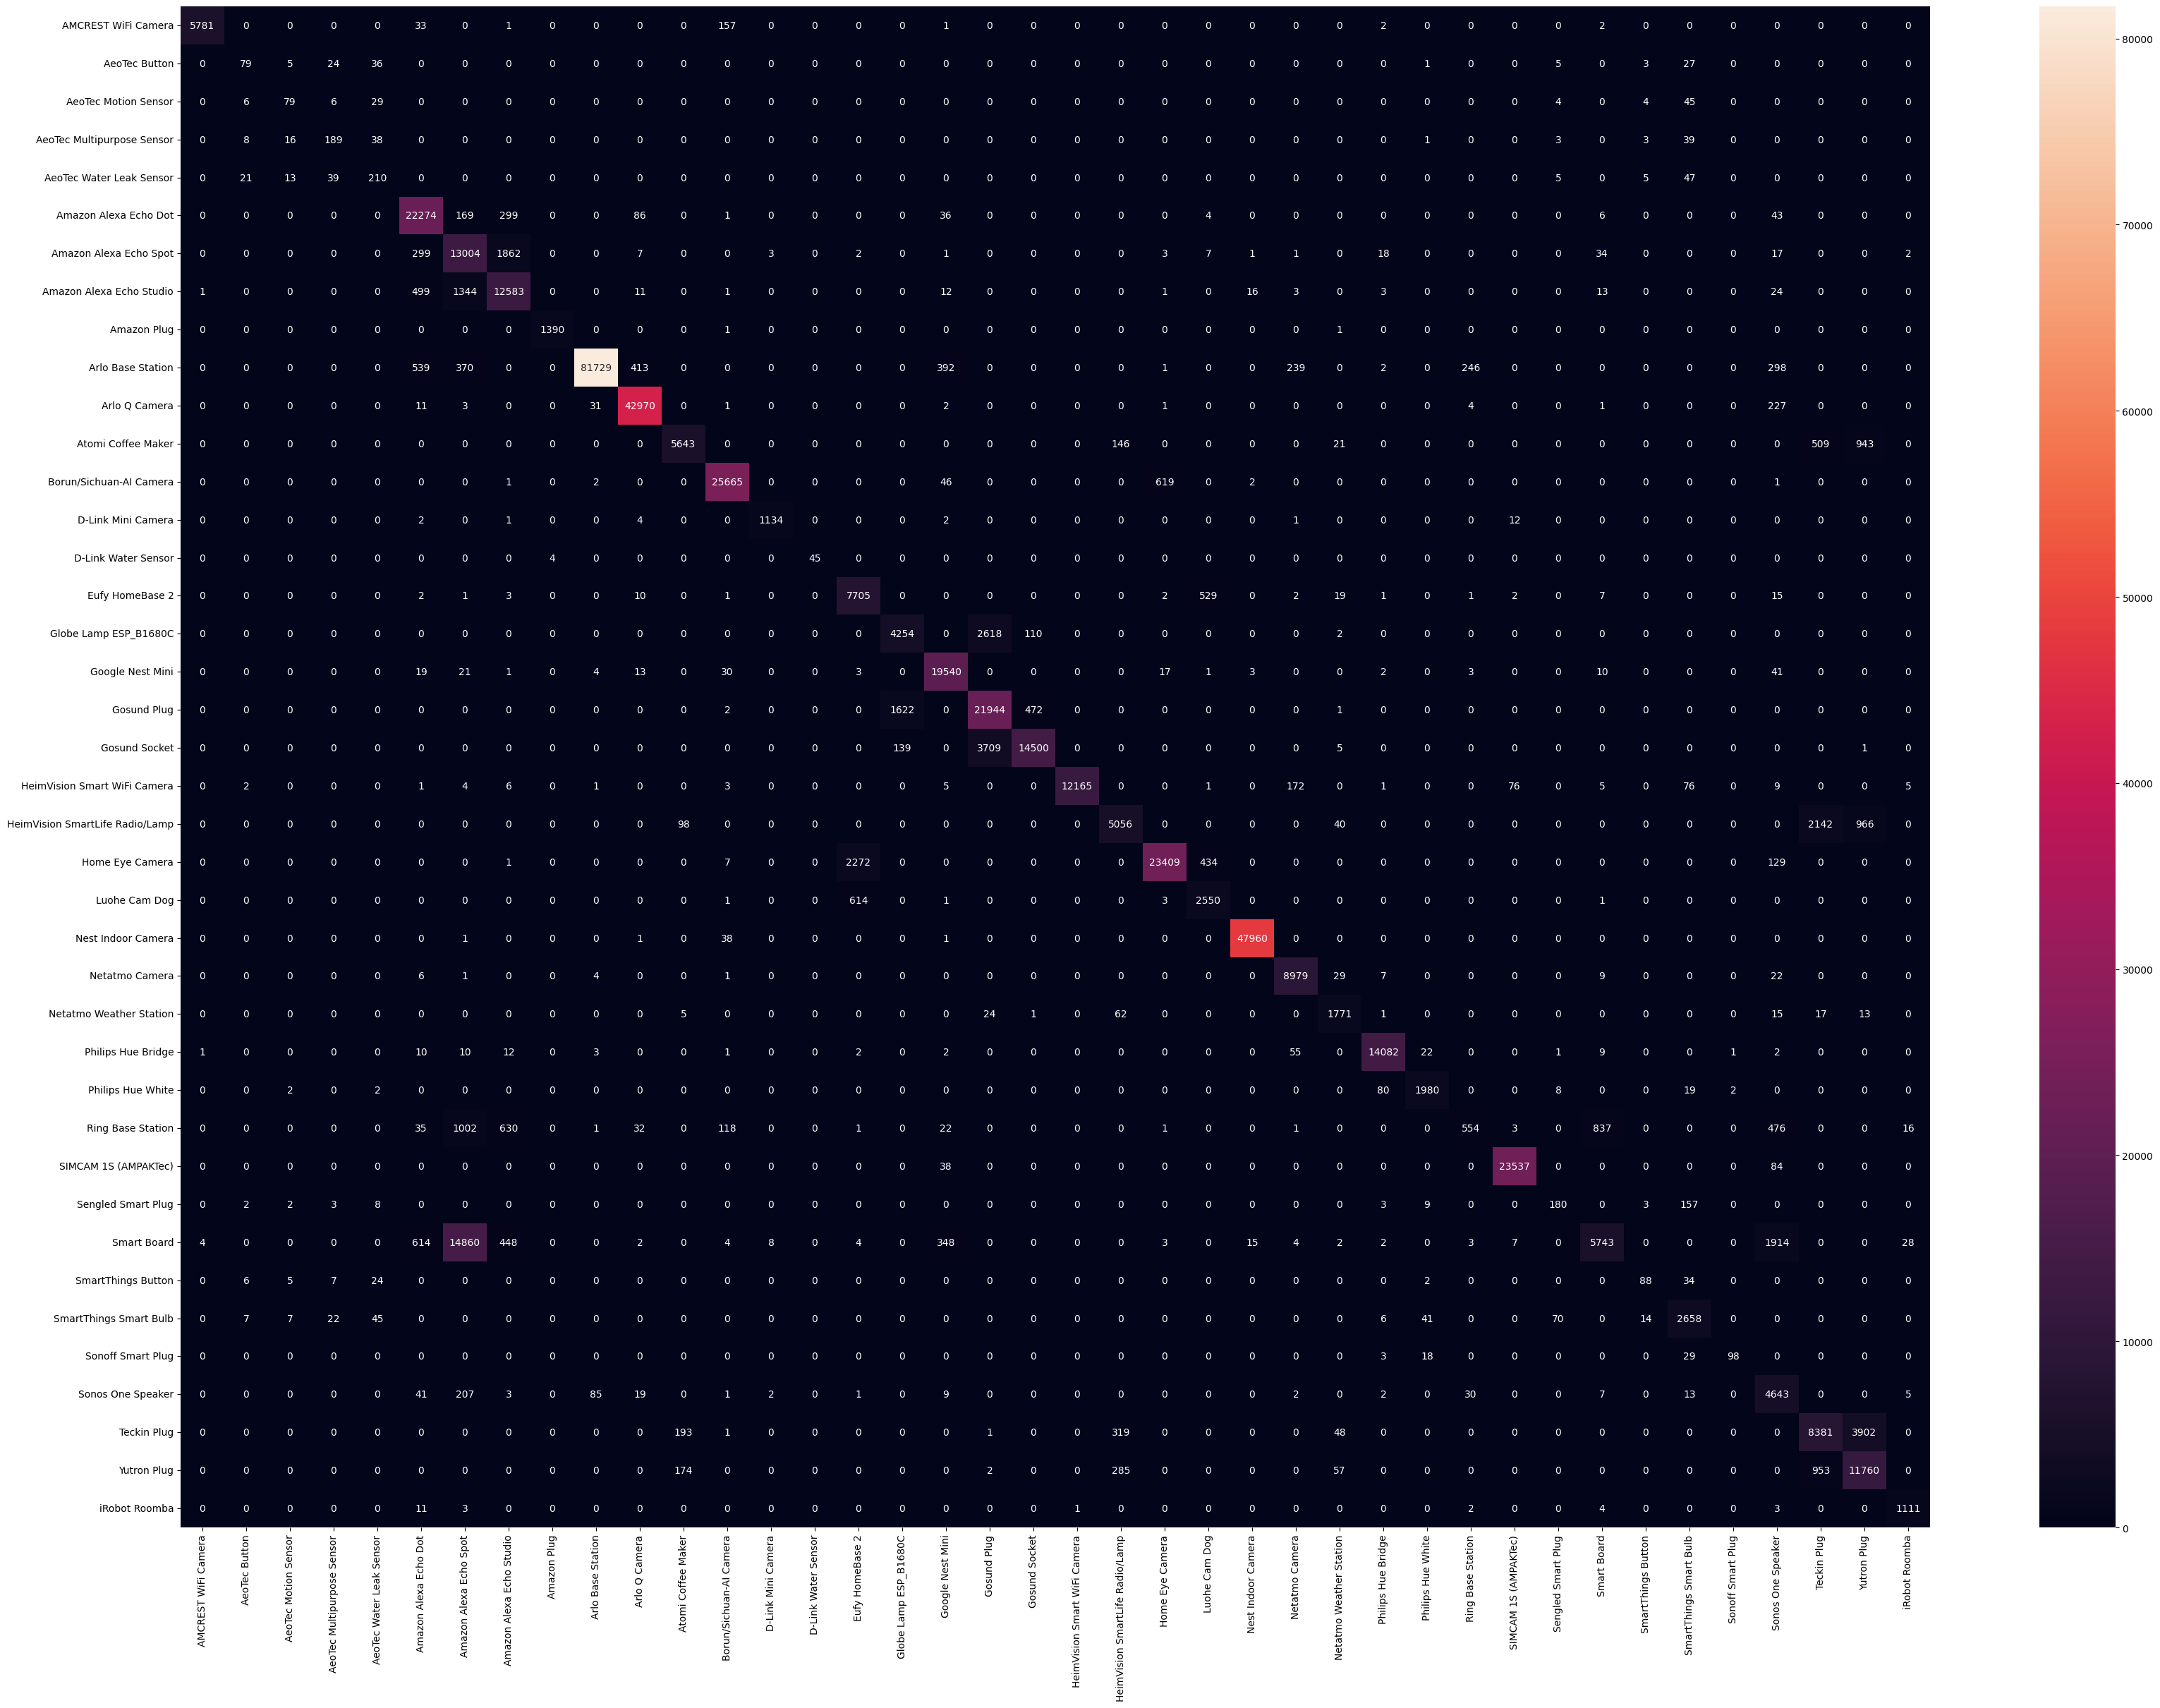

In [19]:
say=0
dataset="./results/other/1/"
folder(dataset)
for ii in TT:
    for iii in T:
        #iii=ii.replace("Train","Test")
        say+=1
        train=ii
        test=iii
        mixed=False
        step=1
        sayac=1
        output_csv=f"{dataset}/@{ii[7:-4]}@{iii[7:-4]}.csv"
        print(f"{ii[7:-4]}-{iii[7:-4]}")
        target_names=target_name(test)
        ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


ACTIVE_TrainInteractions_ALL_clean-ACTIVE_TestInteractions_ALL_clean
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.949    0.843   0.905  0.843  0.844  0.946      0    2.99      0.27       9.61
 1  results/other/13_13    1     2  DT    0.949    0.843   0.904  0.843  0.844  0.946      0    2.946     0.255      9.775
 2  results/other/13_13    2     3  DT    0.95     0.843   0.905  0.843  0.845  0.946      0    2.945     0.3        9.48
 3  results/other/13_13    3     4  DT    0.949    0.843   0.905  0.843  0.845  0.946      0    2.807     0.28       9.257
 4  results/other/13_13    4     5  DT    0.949    0.843   0.904  0.843  0.844  0.946      0    3         0.259      9.152
 5  results/other/13_13    5     6  DT    0.949    0.843   0.905  0.843 

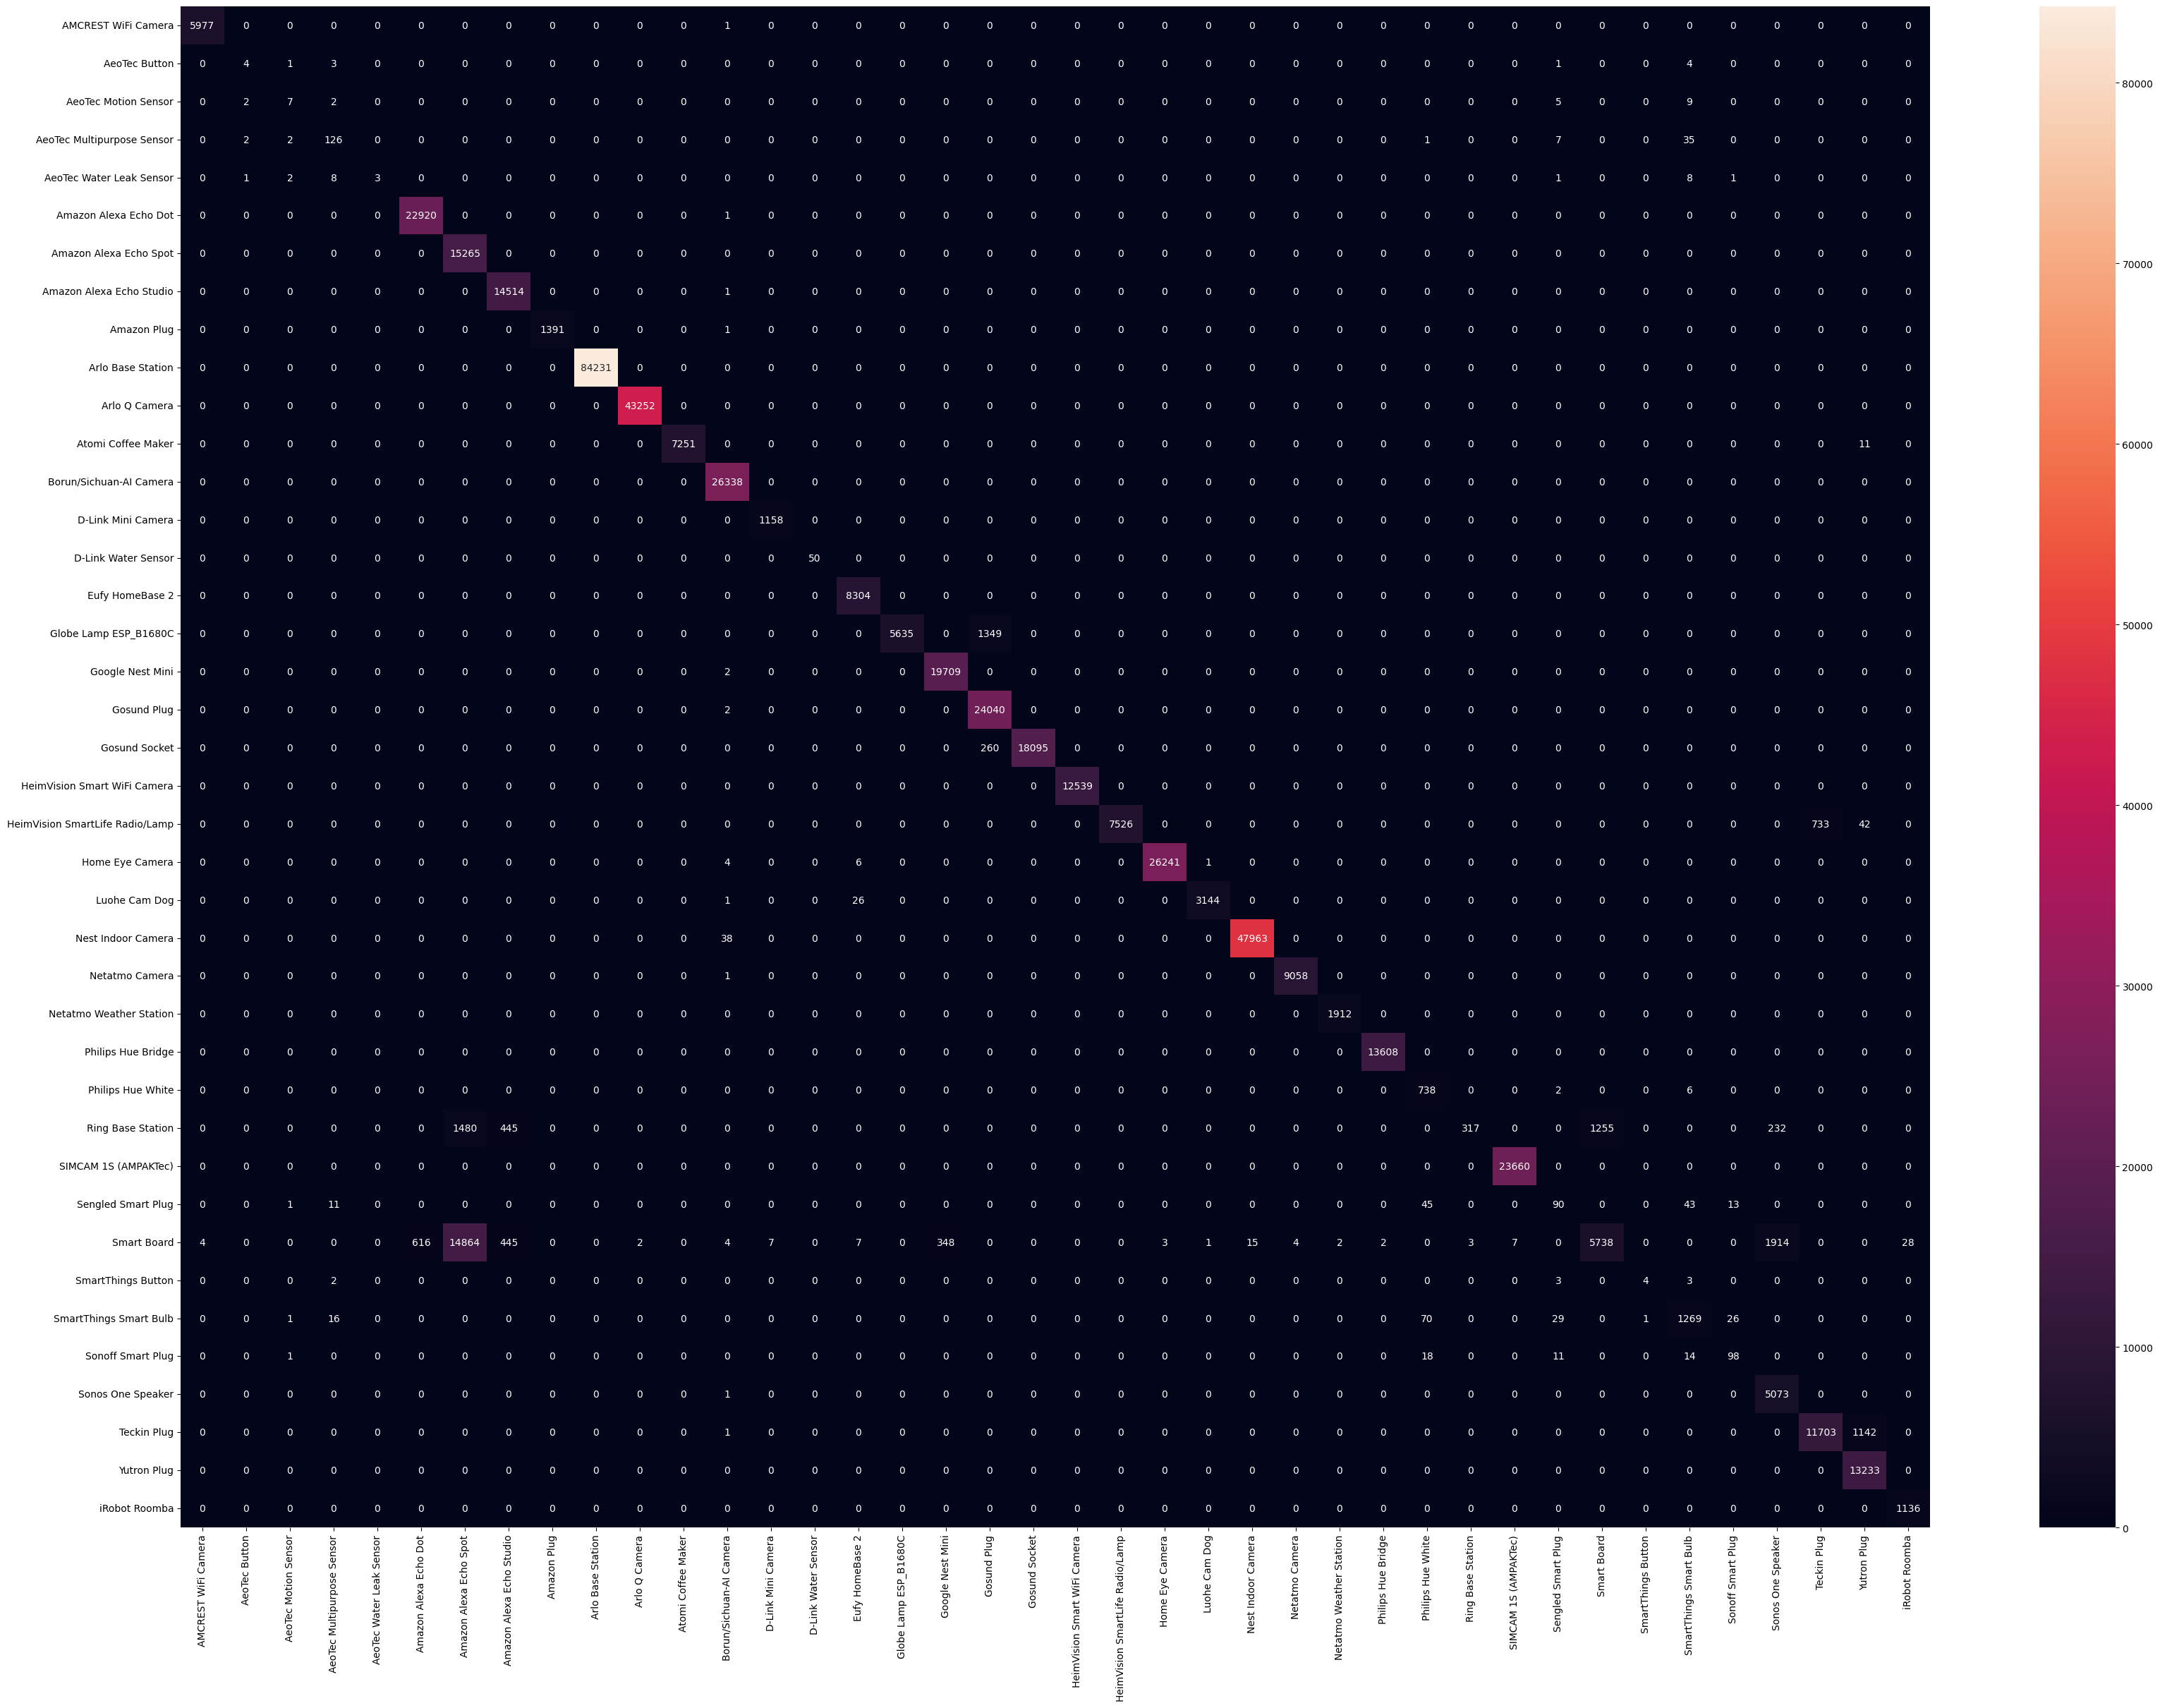

ACTIVE_TrainInteractions_ALL_clean-ACTIVE_TestPower_ALL_clean
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.944    0.796   0.826  0.796  0.778   0.94      0    2.953     0.251     10.114
 1  results/other/13_13    1     2  DT    0.944    0.796   0.827  0.796  0.778   0.94      0    2.935     0.235      9.418
 2  results/other/13_13    2     3  DT    0.944    0.796   0.827  0.796  0.778   0.94      0    2.968     0.301      9.639
 3  results/other/13_13    3     4  DT    0.944    0.797   0.826  0.797  0.778   0.94      0    2.861     0.251      9.603
 4  results/other/13_13    4     5  DT    0.944    0.796   0.826  0.796  0.778   0.94      0    2.779     0.252      9.547
 5  results/other/13_13    5     6  DT    0.944    0.796   0.826  0.796  0.77

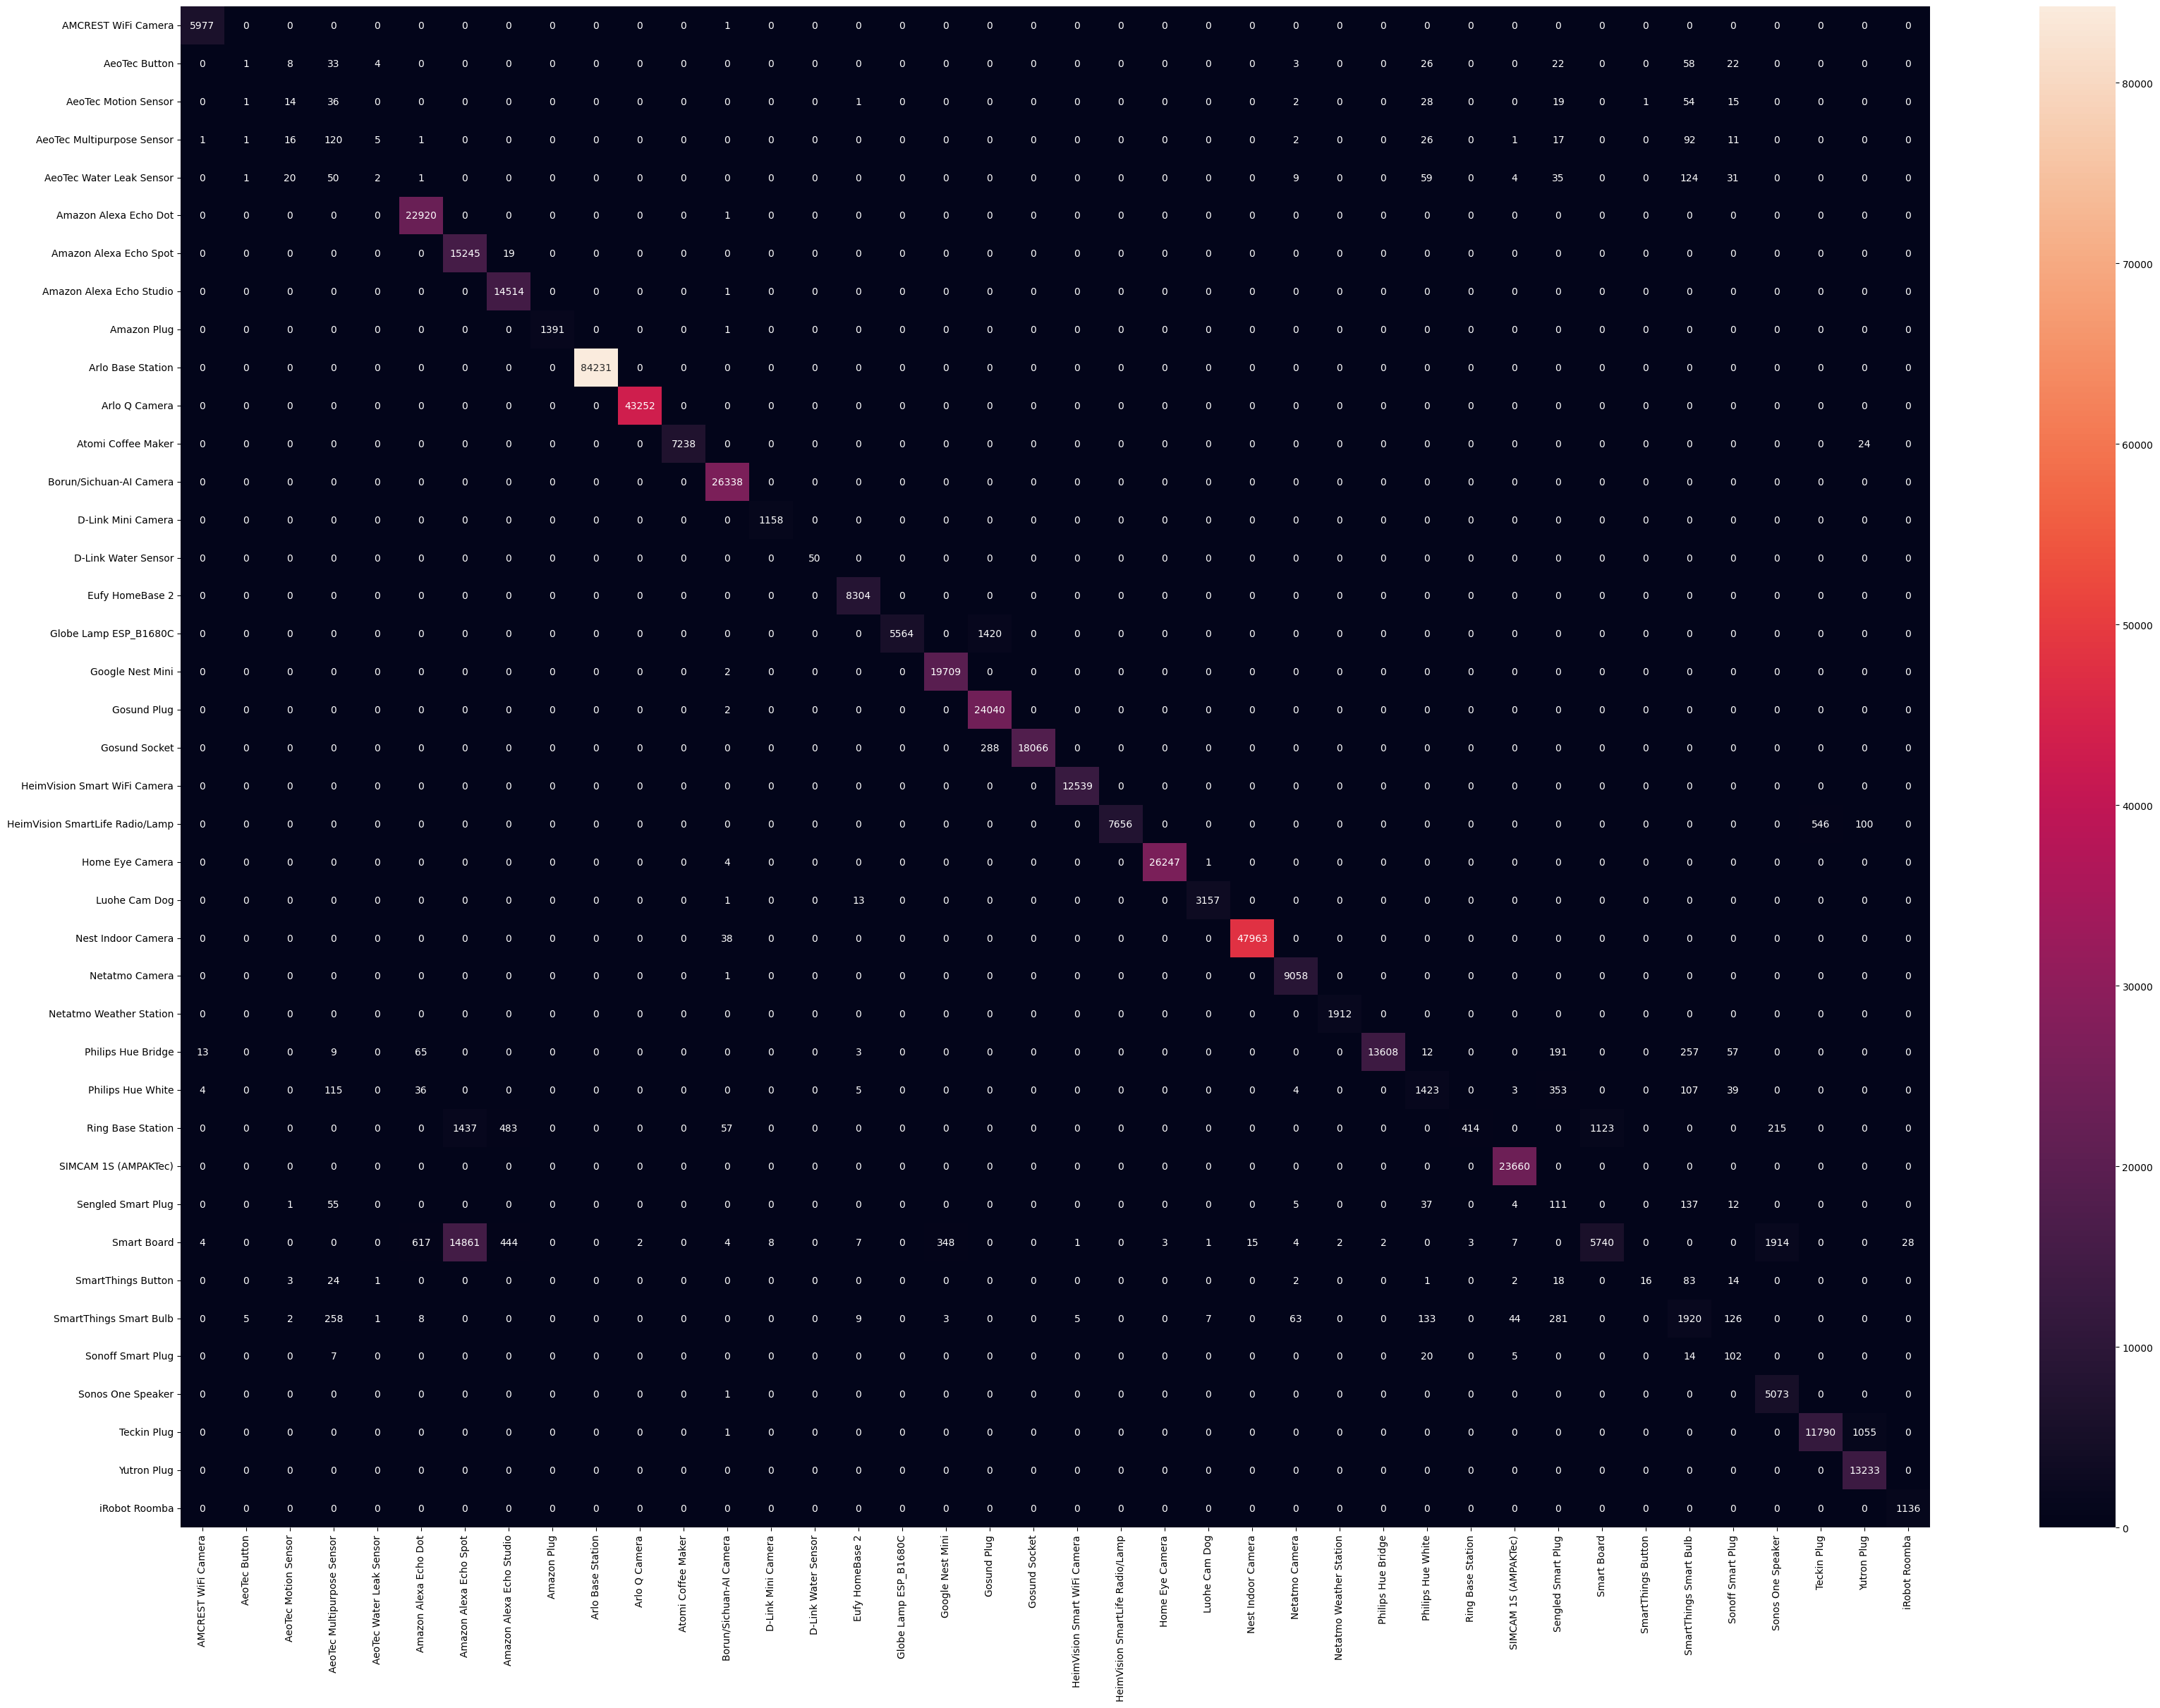

ACTIVE_TrainPower_ALL_clean-ACTIVE_TestInteractions_ALL_clean
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.949    0.801   0.83   0.801  0.788  0.945      0    3.087     0.236      9.471
 1  results/other/13_13    1     2  DT    0.949    0.801   0.833  0.801  0.788  0.945      0    2.855     0.267      9.102
 2  results/other/13_13    2     3  DT    0.948    0.8     0.83   0.8    0.787  0.945      0    3.027     0.267      9.578
 3  results/other/13_13    3     4  DT    0.948    0.801   0.83   0.801  0.788  0.945      0    2.962     0.252      9.483
 4  results/other/13_13    4     5  DT    0.949    0.801   0.831  0.801  0.788  0.945      0    2.986     0.251     10.005
 5  results/other/13_13    5     6  DT    0.949    0.801   0.83   0.801  0.78

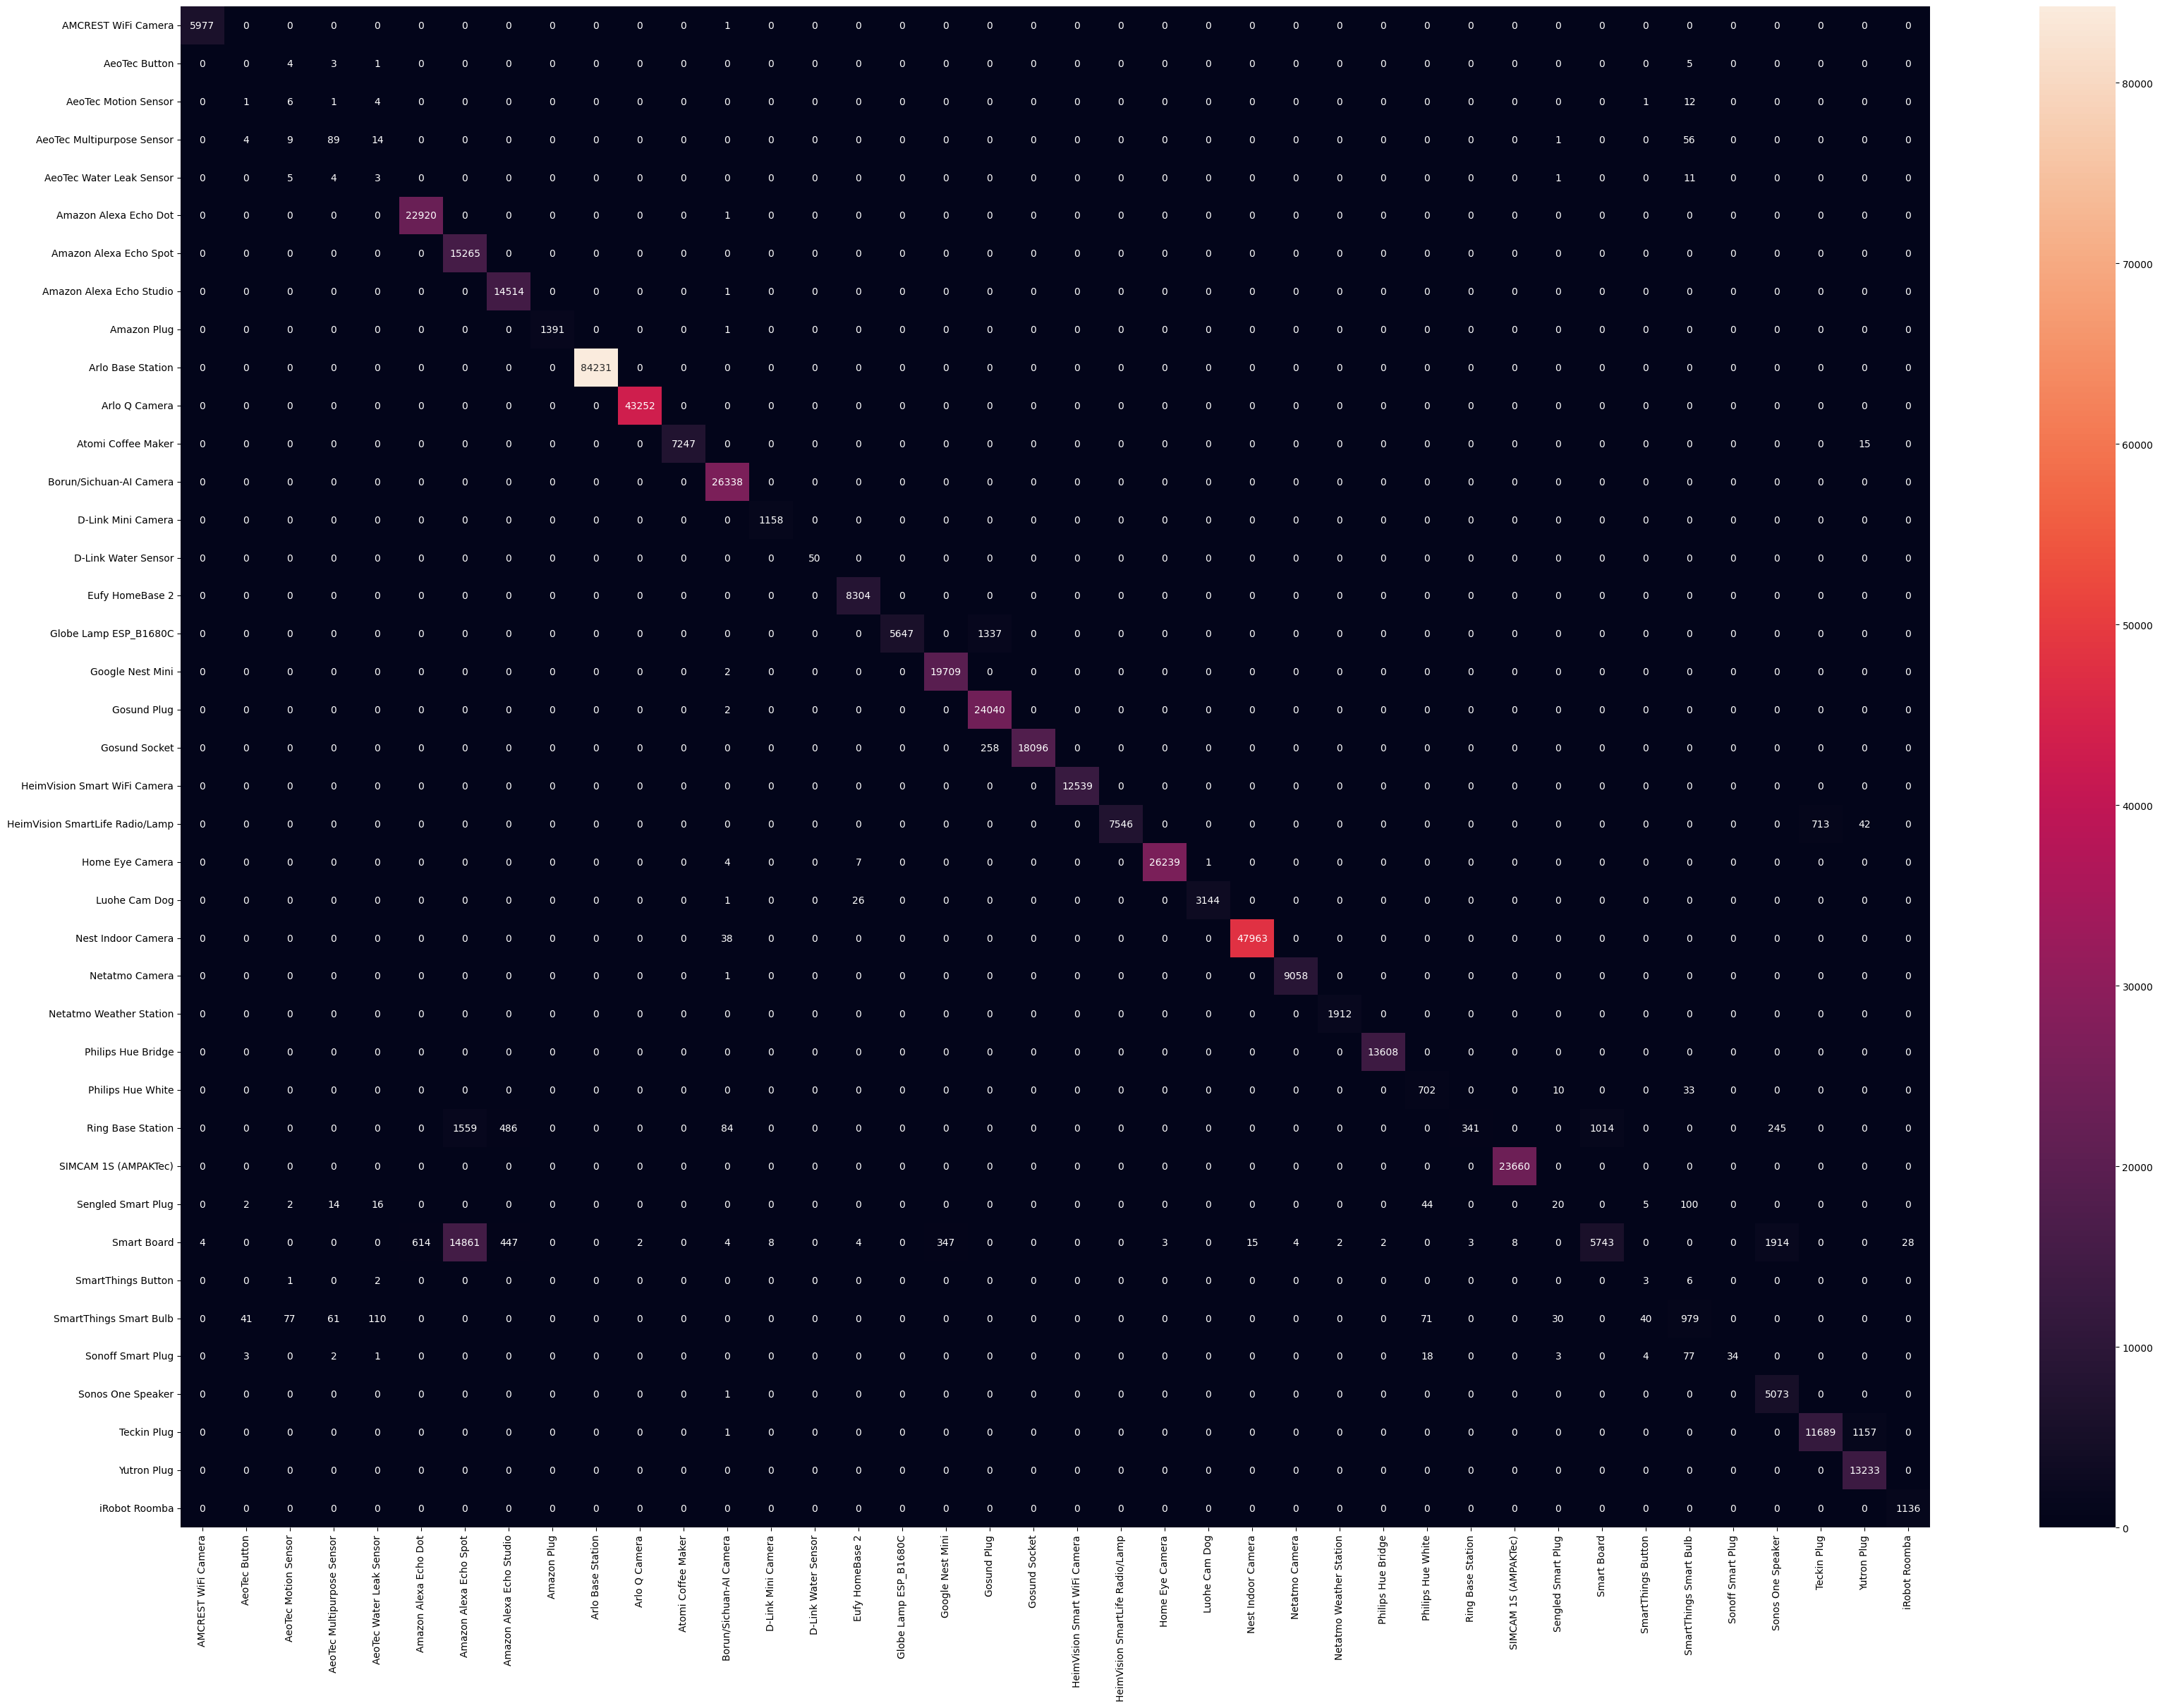

ACTIVE_TrainPower_ALL_clean-ACTIVE_TestPower_ALL_clean
    Dataset                T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T    Al-Time
--  -------------------  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------  ---------
 0  results/other/13_13    0     1  DT    0.949    0.866   0.906  0.866  0.867  0.945      0    2.53      0.256      9.322
 1  results/other/13_13    1     2  DT    0.949    0.866   0.909  0.866  0.867  0.945      0    2.959     0.235      9.522
 2  results/other/13_13    2     3  DT    0.949    0.866   0.906  0.866  0.868  0.945      0    2.95      0.267      9.887
 3  results/other/13_13    3     4  DT    0.949    0.866   0.906  0.866  0.868  0.945      0    3.094     0.251      9.3
 4  results/other/13_13    4     5  DT    0.949    0.866   0.909  0.866  0.867  0.945      0    2.983     0.235      9.304
 5  results/other/13_13    5     6  DT    0.949    0.866   0.906  0.866  0.867  0.945 

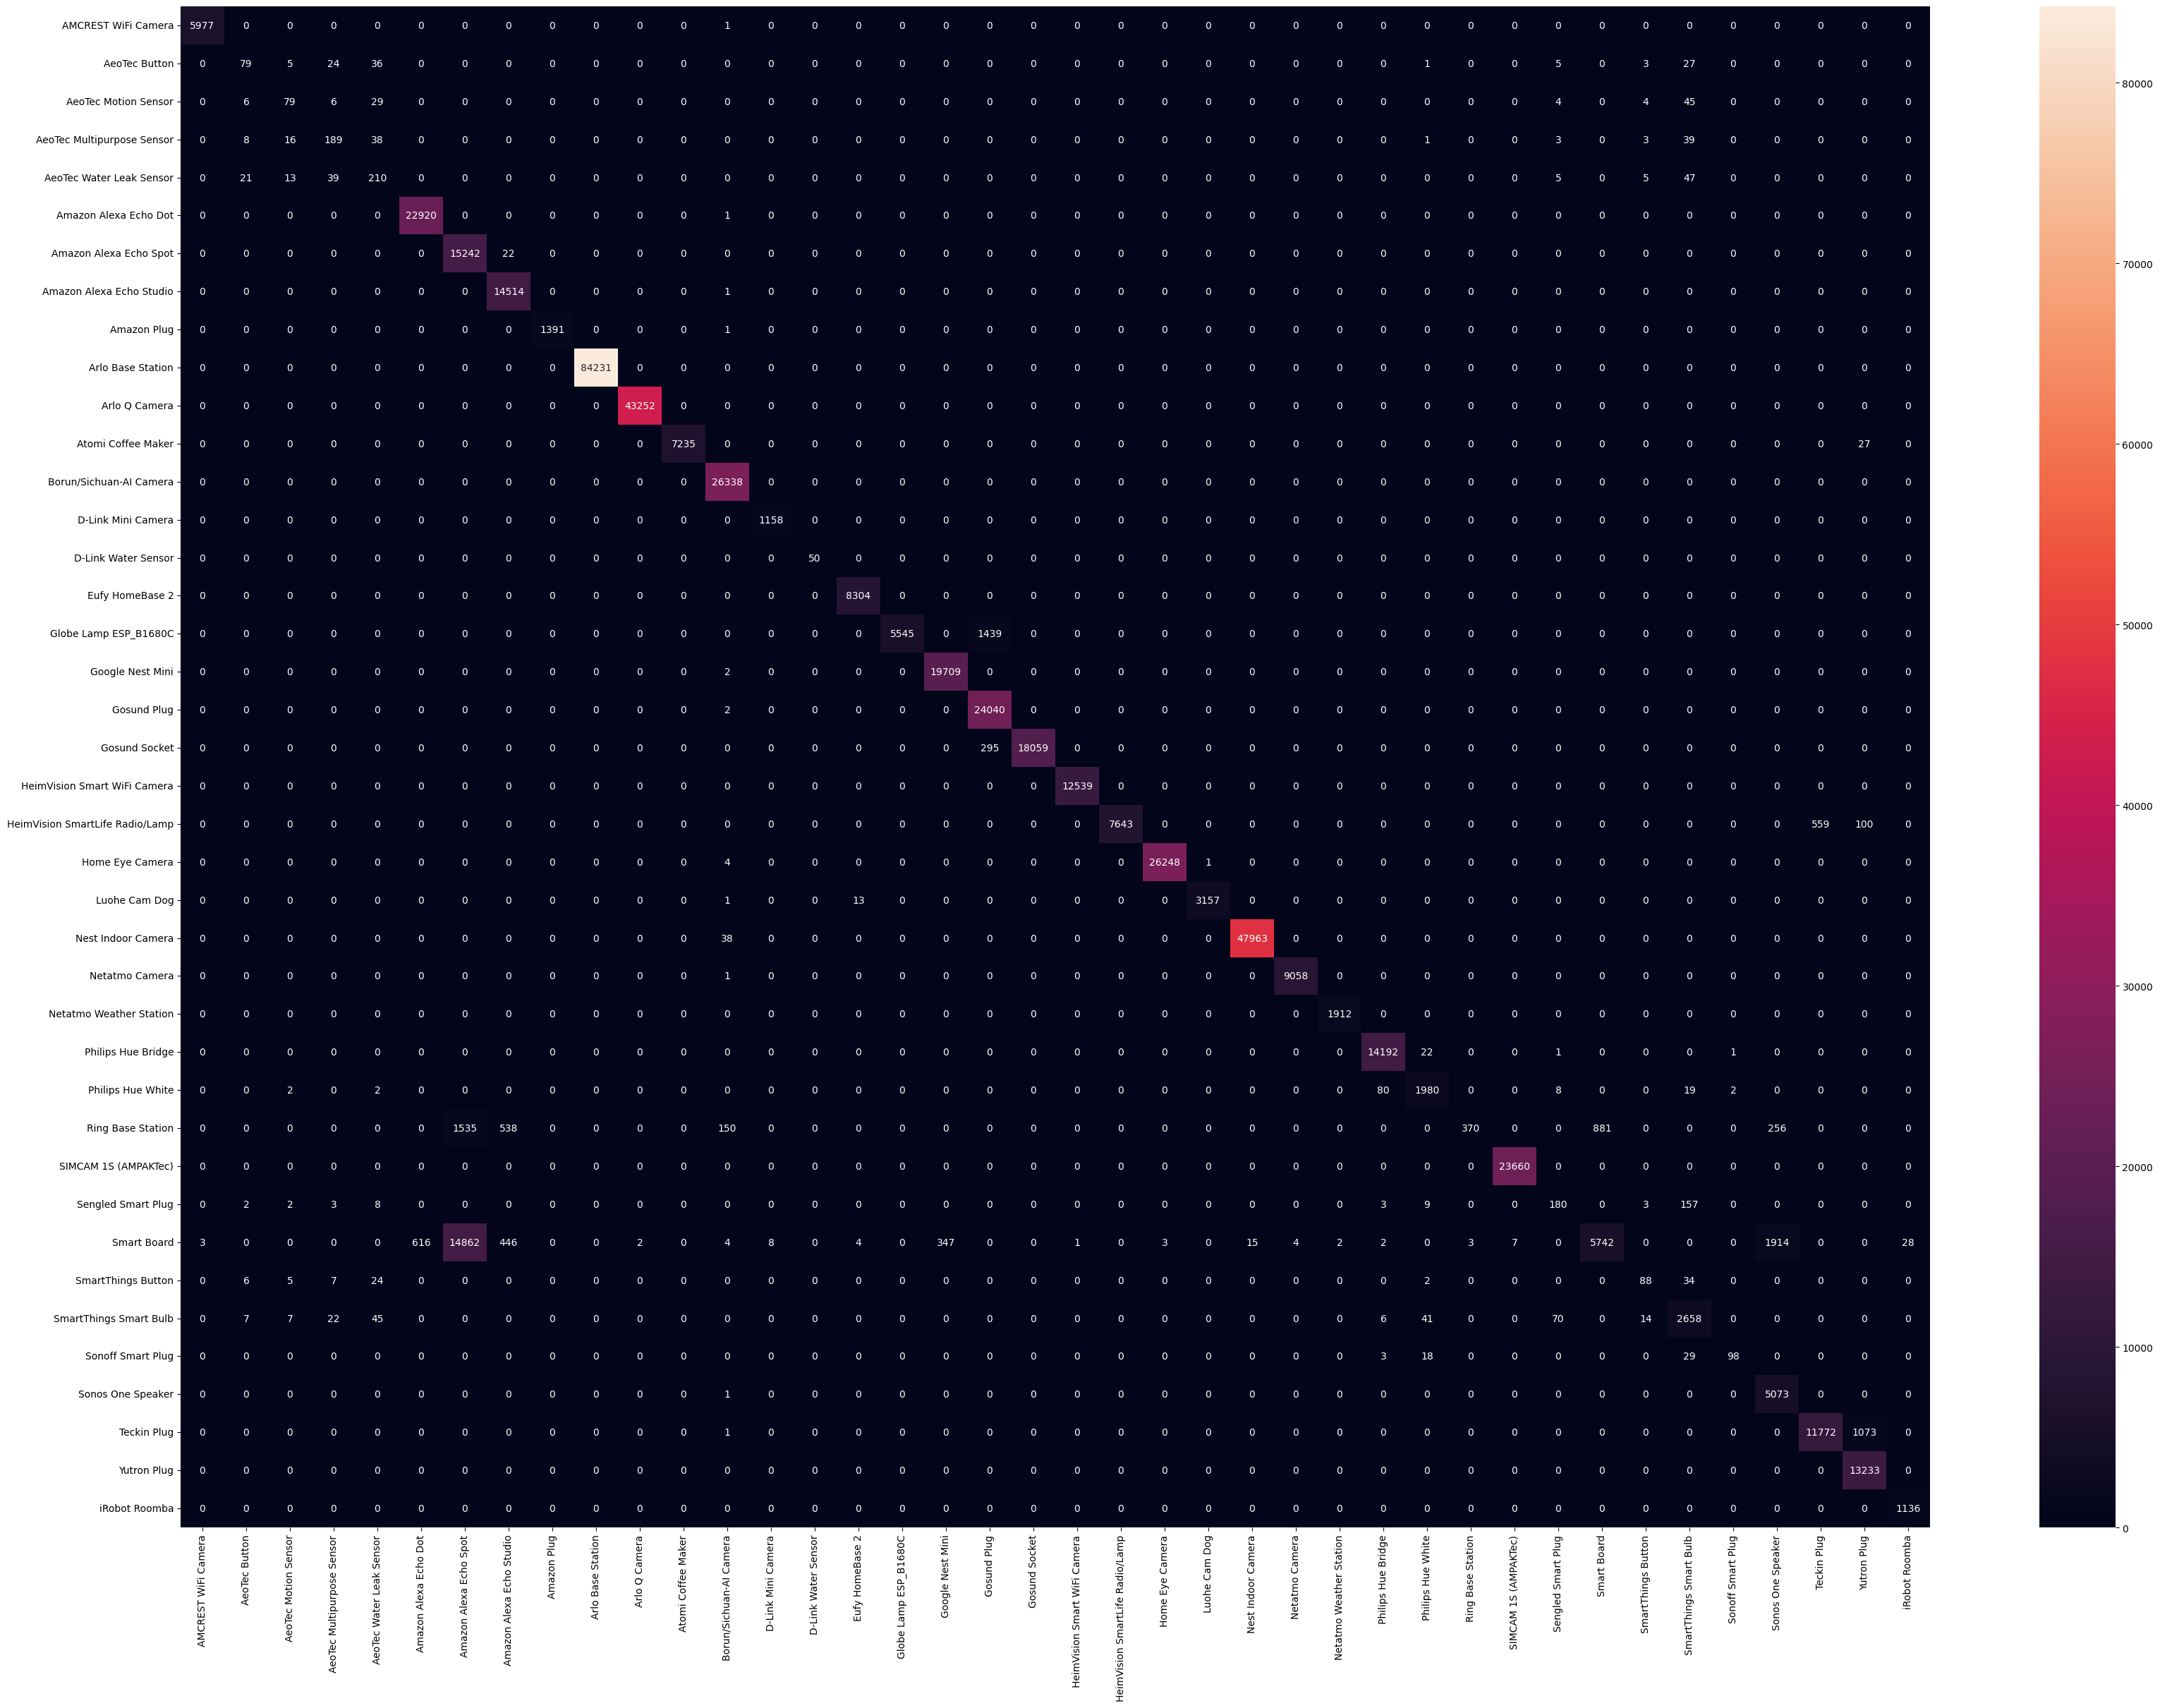

In [20]:
say=0
dataset="./results/other/13/"
folder(dataset)
for ii in TT:
    for iii in T:
        #iii=ii.replace("Train","Test")
        say+=1
        train=ii
        test=iii
        mixed=True
        step=13
        sayac=1
        output_csv=f"{dataset}/@{ii[7:-4]}@{iii[7:-4]}.csv"
        print(f"{ii[7:-4]}-{iii[7:-4]}")
        target_names=target_name(test)
        ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   
